# Credit Card Fraud – Anomaly Detection & Explainability

## Dependencies

In [ ]:
%pip -q install numpy pandas joblib cloudpickle matplotlib seaborn shap lime scikit-learn

print("All dependencies for Local Outlier Factor installed")

All dependencies for Local Outlier Factor installed


## Imports

In [ ]:
import os
import json
import joblib
import cloudpickle
import numpy as np
import pandas as pd
import re
from pathlib import Path
from itertools import combinations

import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.colors import LinearSegmentedColormap
import shap
import lime
import lime.lime_tabular

from sklearn.neighbors import LocalOutlierFactor
from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    precision_score, recall_score, f1_score,
    roc_auc_score, average_precision_score,
    confusion_matrix, classification_report
)
from sklearn.preprocessing import StandardScaler, FunctionTransformer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

## Parameters

In [ ]:
from google.colab import drive
drive.mount('/content/drive')
from pathlib import Path

RANDOM_STATE = 42
PREPROCESSOR_TYPE = 'kernel'

MODEL_NAME = "local_outlier_factor_ulb"
RESULTS_DIR = Path('/content/drive/MyDrive/Colab Notebooks/MA/Credit_Card_Fraud_ULB/results/hyperparams')
DATA_DIR = Path("/content/drive/MyDrive/Colab Notebooks/MA/Credit_Card_Fraud_ULB/processed_data")
PREPROCESSOR_FILE = Path(f"preprocessor_{PREPROCESSOR_TYPE}.pkl")

TRAIN_SAMPLE_SIZE = 30000

N_FRAUD_SAMPLES_EXPLAIN = 50
N_NORMAL_SAMPLES_EXPLAIN = 150
EVAL_PANEL_SIZE = N_FRAUD_SAMPLES_EXPLAIN + N_NORMAL_SAMPLES_EXPLAIN

BACKGROUND_SIZE = 500
SHAP_KMEANS_K = 100

LIME_NUM_SAMPLES = 5000
LIME_KERNEL_WIDTH = 7.5
LIME_NUM_FEATURES = 15

SHAP_NSAMPLES = 2048

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## Data Loading

In [ ]:
import numpy as np
from scipy.sparse import load_npz
from pathlib import Path
import pickle

print("--- Loading raw data and pre-existing preprocessor ---")

data_dir = Path("/content/drive/MyDrive/Colab Notebooks/MA/Credit_Card_Fraud_ULB/processed_data")
preprocessor_dir = Path("/content/drive/MyDrive/Colab Notebooks/MA/Credit_Card_Fraud_ULB/preprocessors")

PREPROCESSOR_TYPE = 'kernel'

def load_features(data_dir, preprocessor_type, data_name):
    """Loads pre-computed features, handling both sparse and dense formats."""
    base_path = data_dir / f"{data_name}_{preprocessor_type}"
    path_npz = base_path.with_suffix('.npz')
    path_npy = base_path.with_suffix('.npy')

    if path_npz.exists():
        return load_npz(path_npz)
    elif path_npy.exists():
        return np.load(path_npy)
    else:
        raise FileNotFoundError(f"Data not found for {base_path}")

print(f"--- Loading data for '{PREPROCESSOR_TYPE}' preprocessor ---")

X_train_scaled = load_features(data_dir, PREPROCESSOR_TYPE, 'X_train_transformed')
X_test_scaled = load_features(data_dir, PREPROCESSOR_TYPE, 'X_test_transformed')
y_train = np.load(data_dir / "y_train.npy")
y_test = np.load(data_dir / "y_test.npy")

preprocessor_path = preprocessor_dir / f"preprocessor_{PREPROCESSOR_TYPE}.pkl"
try:
    preprocessor = joblib.load(preprocessor_path)
    feature_names = preprocessor.get_feature_names_out()
    print("Preprocessor loaded and feature names extracted successfully.")
except FileNotFoundError:
    print(f"Error: Preprocessor file not found at {preprocessor_path}")
    feature_names = [f'feature_{i}' for i in range(X_train_scaled.shape[1])]

print("Data loaded successfully.")
print("X_train shape:", X_train_scaled.shape)
print("X_test shape:", X_test_scaled.shape)

--- Loading raw data and pre-existing preprocessor ---
--- Loading data for 'kernel' preprocessor ---
Preprocessor loaded and feature names extracted successfully.
Data loaded successfully.
X_train shape: (227845, 30)
X_test shape: (56962, 30)


## Local Outlier Factor Model

### Hyperparameter Tuning

In [ ]:
import numpy as np
from scipy.sparse import issparse
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import average_precision_score, roc_auc_score
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import LocalOutlierFactor

def _to_dense(data):
    return data.toarray() if issparse(data) else data

MAX_TUNE_TOTAL = 20000
NORMALS_PER_POS = 3
N_FOLDS = 3

param_grid = {
    "n_neighbors": [10, 20, 35, 50, 100],
    "leaf_size": [30],
    "metric": ["minkowski"],
    "p": [1, 2],  # Manhattan vs Euclidean
}

# Build tuning subset from current training split (expects X_train, y_train to exist)
y_arr = np.asarray(y_train).astype(int)
pos_idx = np.where(y_arr == 1)[0]
neg_idx = np.where(y_arr == 0)[0]

n_pos = len(pos_idx)
n_neg = min(len(neg_idx), max(5000, min(NORMALS_PER_POS * n_pos, MAX_TUNE_TOTAL - n_pos)))
_rng = np.random.default_rng(RANDOM_STATE)
neg_sample = _rng.choice(neg_idx, size=n_neg, replace=False) if n_neg > 0 else np.array([], dtype=int)

tune_idx = np.concatenate([pos_idx, neg_sample])
_rng.shuffle(tune_idx)

X_tune = _to_dense(X_train_scaled[tune_idx])
y_tune = y_arr[tune_idx]

print(f"Tuning subset -> X: {X_tune.shape}, positives: {y_tune.sum()}, normals: {(y_tune==0).sum()}")

def _lof_cv_score(X, y, params, n_splits=N_FOLDS, random_state=RANDOM_STATE, use_ap=True):
    """
    Semi-supervised CV for LOF:
    - Scale within each fold.
    - Fit LOF on normals-only in training fold.
    - Score validation fold with AP (preferred) or ROC-AUC on -score_samples.
    """
    y = np.asarray(y).astype(int)
    n_pos = int(np.sum(y == 1))
    n_splits = max(2, min(n_splits, n_pos)) if n_pos > 0 else 2

    cv = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=random_state)
    scores = []
    for tr_idx, va_idx in cv.split(X, y):
        X_tr, y_tr = X[tr_idx], y[tr_idx]
        X_va, y_va = X[va_idx], y[va_idx]

        X_tr_normals = X_tr[y_tr == 0]

        pipe = Pipeline([
            ("scaler", StandardScaler(with_mean=not issparse(X_tr_normals))),
            ("lof", LocalOutlierFactor(
                novelty=True,
                n_neighbors=params.get("n_neighbors", 35),
                leaf_size=params.get("leaf_size", 30),
                metric=params.get("metric", "minkowski"),
                p=params.get("p", 2),
                contamination=0.01
            ))
        ])
        pipe.fit(X_tr_normals)

        X_va_scaled = pipe.named_steps["scaler"].transform(X_va)
        val_scores = -pipe.named_steps["lof"].score_samples(X_va_scaled)
        s = average_precision_score(y_va, val_scores) if use_ap else roc_auc_score(y_va, val_scores)
        scores.append(s)

    return float(np.mean(scores)) if scores else 0.5

print("Starting FAST LOF hyperparameter tuning (semi-supervised CV, scoring=AP)...")
best_params, best_score = None, -np.inf
for n_nb in param_grid["n_neighbors"]:
    for leaf in param_grid["leaf_size"]:
        for metric in param_grid["metric"]:
            for p in param_grid["p"]:
                params = {"n_neighbors": n_nb, "leaf_size": leaf, "metric": metric, "p": p}
                s = _lof_cv_score(X_tune, y_tune, params, n_splits=N_FOLDS, random_state=RANDOM_STATE, use_ap=True)
                print(f"Params {params} -> CV AP: {s:.4f}")
                if s > best_score:
                    best_score, best_params = s, params

TUNED_PARAMS = best_params
print("Best LOF params:", TUNED_PARAMS)
print("Best CV AP:", best_score)

Tuning subset -> X: (5394, 30), positives: 394, normals: 5000
Starting FAST LOF hyperparameter tuning (semi-supervised CV, scoring=AP)...
Params {'n_neighbors': 10, 'leaf_size': 30, 'metric': 'minkowski', 'p': 1} -> CV AP: 0.8480
Params {'n_neighbors': 10, 'leaf_size': 30, 'metric': 'minkowski', 'p': 2} -> CV AP: 0.8591
Params {'n_neighbors': 20, 'leaf_size': 30, 'metric': 'minkowski', 'p': 1} -> CV AP: 0.8646
Params {'n_neighbors': 20, 'leaf_size': 30, 'metric': 'minkowski', 'p': 2} -> CV AP: 0.8665
Params {'n_neighbors': 35, 'leaf_size': 30, 'metric': 'minkowski', 'p': 1} -> CV AP: 0.8635
Params {'n_neighbors': 35, 'leaf_size': 30, 'metric': 'minkowski', 'p': 2} -> CV AP: 0.8633
Params {'n_neighbors': 50, 'leaf_size': 30, 'metric': 'minkowski', 'p': 1} -> CV AP: 0.8592
Params {'n_neighbors': 50, 'leaf_size': 30, 'metric': 'minkowski', 'p': 2} -> CV AP: 0.8607
Params {'n_neighbors': 100, 'leaf_size': 30, 'metric': 'minkowski', 'p': 1} -> CV AP: 0.8388
Params {'n_neighbors': 100, 'leaf

### Train and Evaluate Model

--- Training Full LOF Model ---
Training Local Outlier Factor with n_neighbors=30...
Model training complete.
\n--- Evaluating model on Test Set ---
Precision: 0.0000
Recall:    0.0000
F1-Score:  0.0000
ROC AUC:   0.5117
PR AUC:    0.0028


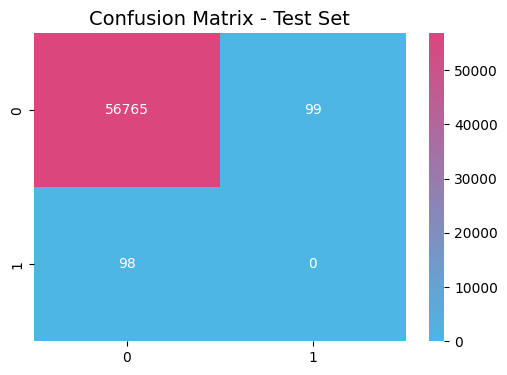

In [ ]:
N_NEIGHBORS = 30

CONTAMINATION_RATE = y_train.mean()
custom_cmap = LinearSegmentedColormap.from_list('custom', ['#4db6e3', '#db467d'])

def train_lof(X_train_data, contamination=CONTAMINATION_RATE, n_neighbors=N_NEIGHBORS):
    print(f"Training Local Outlier Factor with n_neighbors={n_neighbors}...")
    model = LocalOutlierFactor(
        n_neighbors=n_neighbors,
        contamination=contamination,
        novelty=True,
        n_jobs=-1
    )
    model.fit(X_train_data)
    print("Model training complete.")
    return model

def evaluate_model(model, X, y, data_label="Test Set"):
    print(f"\\n--- Evaluating model on {data_label} ---")
    scores = -model.score_samples(X)
    threshold = np.percentile(scores, 100 * (1 - model.contamination))
    y_pred = (scores >= threshold).astype(int)

    metrics = {
        "precision": precision_score(y, y_pred, zero_division=0),
        "recall": recall_score(y, y_pred, zero_division=0),
        "f1": f1_score(y, y_pred, zero_division=0),
        "roc_auc": roc_auc_score(y, scores),
        "pr_auc": average_precision_score(y, scores),
    }

    print(f"Precision: {metrics['precision']:.4f}")
    print(f"Recall:    {metrics['recall']:.4f}")
    print(f"F1-Score:  {metrics['f1']:.4f}")
    print(f"ROC AUC:   {metrics['roc_auc']:.4f}")
    print(f"PR AUC:    {metrics['pr_auc']:.4f}")

    cm = confusion_matrix(y, y_pred)
    plt.figure(figsize=(6, 4))
    sns.heatmap(cm, annot=True, cmap=custom_cmap, fmt="g")
    plt.title(f"Confusion Matrix - {data_label}", fontsize=14)
    plt.show()

    return y_pred, scores, metrics, cm

print("--- Training Full LOF Model ---")
lof_model_full = train_lof(X_train_scaled)

lof_preds_full, lof_scores_full, lof_metrics_full, lof_cm_full = evaluate_model(lof_model_full, X_test_scaled, y_test)

### Build Background & Evaluation Subsets

In [ ]:
normal_indices_train = np.where(y_train == 0)[0]
background_indices = np.random.choice(normal_indices_train, size=BACKGROUND_SIZE, replace=False)
background_data = X_train_scaled[background_indices]

fraud_indices_test = np.where(y_test == 1)[0]
normal_indices_test = np.where(y_test == 0)[0]
sampled_fraud_indices = np.random.choice(fraud_indices_test, size=N_FRAUD_SAMPLES_EXPLAIN, replace=False)
sampled_normal_indices = np.random.choice(normal_indices_test, size=N_NORMAL_SAMPLES_EXPLAIN, replace=False)

eval_indices = np.concatenate([sampled_fraud_indices, sampled_normal_indices])
np.random.shuffle(eval_indices)
eval_data = X_test_scaled[eval_indices]
eval_labels = y_test[eval_indices]

print('\\nShapes of the created subsets for explainability:')
print(f'background_data shape: {background_data.shape}')
print(f'eval_data shape:       {eval_data.shape}')

\nShapes of the created subsets for explainability:
background_data shape: (500, 30)
eval_data shape:       (200, 30)


## Explain with SHAP KernelExplainer

--- Generating SHAP Explanations (Full Model) [Speed-Optimized] ---
Summarizing background data from 500 to 50 samples using k-means...
Explaining 1 evaluation rows out of 200 total...


  0%|          | 0/1 [00:00<?, ?it/s]

SHAP values computed. Plotting summary...


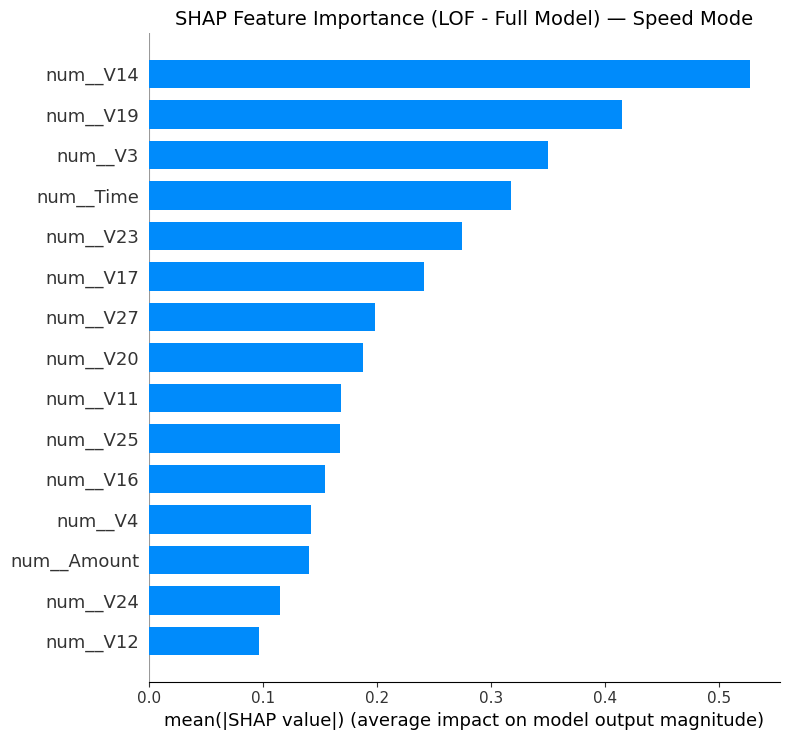

In [ ]:
import numpy as np
import shap
import matplotlib.pyplot as plt
import pandas as pd

print("--- Generating SHAP Explanations (Full Model) [Speed-Optimized] ---")

NUM_EXPLANATION_INSTANCES = 20

background_data = background_data.astype(np.float32, copy=False)
eval_data = eval_data.astype(np.float32, copy=False)

SHAP_KMEANS_K = min(50, background_data.shape[0])

print(f"Summarizing background data from {background_data.shape[0]} to {SHAP_KMEANS_K} samples using k-means...")
background_data_summary = shap.kmeans(background_data, SHAP_KMEANS_K)

MAX_EVAL = 1
if eval_data.shape[0] > MAX_EVAL:
    eval_data_used = eval_data[:MAX_EVAL]
else:
    eval_data_used = eval_data

print(f"Explaining {eval_data_used.shape[0]} evaluation rows out of {eval_data.shape[0]} total...")

SHAP_NSAMPLES = 256

explainer = shap.KernelExplainer(
    lambda x: -lof_model_full.score_samples(x),
    background_data_summary,
    link="identity"
)

shap_values = explainer.shap_values(
    eval_data_used,
    nsamples=SHAP_NSAMPLES,
    l1_reg="num_features(15)"
)

print("SHAP values computed. Plotting summary...")

shap.summary_plot(
    shap_values,
    features=eval_data_used,
    feature_names=feature_names,
    plot_type="bar",
    max_display=15,
    show=False
)
plt.title("SHAP Feature Importance (LOF - Full Model) — Speed Mode", fontsize=14)
plt.tight_layout()
plt.show()

## Explain with LIME TabularExplainer

In [ ]:
from IPython.display import display, HTML

print("--- Generating LIME Explanation for a Fraud Instance (Full Model) ---")

def lime_predict_proba_lof(model, instances):
    scores = -model.score_samples(instances)
    prob_fraud = (scores - scores.min()) / (scores.max() - scores.min() + 1e-6)
    prob_normal = 1 - prob_fraud
    return np.vstack((prob_normal, prob_fraud)).T

def explain_with_lime(model, background_data, eval_instance, feature_names, random_state=RANDOM_STATE):
    lime_explainer = lime.lime_tabular.LimeTabularExplainer(
        training_data=background_data,
        feature_names=feature_names,
        class_names=['Normal', 'Fraud'],
        mode='classification',
        kernel_width=LIME_KERNEL_WIDTH,
        discretize_continuous=True,
        random_state=random_state
    )
    explanation = lime_explainer.explain_instance(
        data_row=eval_instance,
        predict_fn=lambda x: lime_predict_proba_lof(model, x),
        num_features=10,
        num_samples=LIME_NUM_SAMPLES
    )
    return explanation

fraud_instance_index = np.where(eval_labels == 1)[0][0]
instance_to_explain = eval_data[fraud_instance_index]

lime_explanation_full = explain_with_lime(lof_model_full, background_data, instance_to_explain, feature_names)

--- Generating LIME Explanation for a Fraud Instance (Full Model) ---


## LIME Stability Test

In [ ]:
print("--- Running LIME Stability Test (Full Model) ---")
N_STABILITY_RUNS = 5
TOP_K_FEATURES = 5

top_k_feature_sets = []
for i in range(N_STABILITY_RUNS):
    explanation = explain_with_lime(
        lof_model_full, background_data, instance_to_explain, feature_names, random_state=RANDOM_STATE + i
    )
    top_features = {re.split(r' [<>]=? ', feature)[0] for feature, weight in explanation.as_list(label=1)[:TOP_K_FEATURES]}
    top_k_feature_sets.append(top_features)
    print(f"  Run {i+1} Top {TOP_K_FEATURES} features: {sorted(list(top_features))}")

jaccard_scores = [len(s1&s2)/len(s1|s2) for s1,s2 in combinations(top_k_feature_sets, 2) if len(s1|s2)>0]
average_jaccard_score = np.mean(jaccard_scores) if jaccard_scores else 0
print(f"\nAverage Jaccard Similarity: {average_jaccard_score:.4f}")

--- Running LIME Stability Test (Full Model) ---
  Run 1 Top 5 features: ['num__V1', 'num__V11', 'num__V18', 'num__V3', 'num__V4']
  Run 2 Top 5 features: ['0.09', 'num__V1', 'num__V16', 'num__V3', 'num__V7']
  Run 3 Top 5 features: ['0.09', 'num__V1', 'num__V21', 'num__V3', 'num__V9']
  Run 4 Top 5 features: ['num__V1', 'num__V18', 'num__V19', 'num__V3', 'num__V7']
  Run 5 Top 5 features: ['-0.25', 'num__Amount', 'num__V10', 'num__V21', 'num__V3']

Average Jaccard Similarity: 0.2619


## Interpretability Metrics

In [ ]:
print("Generating LIME explanations for the full evaluation panel for metric calculation...")
lime_explanations_for_metrics = [explain_with_lime(
    lof_model_full, background_data, instance, feature_names
) for instance in eval_data]
print(f"{len(lime_explanations_for_metrics)} LIME explanations generated.")

def compute_faithfulness_lime(model, eval_data, lime_explanations, feature_names, max_features=10):
    feat_to_idx = {feat: i for i, feat in enumerate(feature_names)}
    total_aucs = []
    for idx, exp in enumerate(lime_explanations):
        original_instance = eval_data[idx].reshape(1, -1)
        lime_features = [re.split(r' [<>]=? ', feat)[0] for feat, _ in exp.as_list(label=1)]
        ranked_idxs = [feat_to_idx[feat] for feat in lime_features if feat in feat_to_idx]
        scores = []
        for k in range(1, min(max_features, len(ranked_idxs)) + 1):
            masked_instance = original_instance.copy()
            masked_instance[0, ranked_idxs[:k]] = 0
            new_score = -model.score_samples(masked_instance)[0]
            scores.append(new_score)
        if not scores: continue
        auc = np.trapezoid(y=scores, x=list(range(1, len(scores) + 1))) / len(scores)
        total_aucs.append(auc)
    return np.mean(total_aucs) if total_aucs else 0.0

def compute_sparsity_lime(lime_explanations, total_num_features):
    if not lime_explanations or total_num_features == 0: return 0.0
    num_explained_features = [len(exp.as_list(label=1)) for exp in lime_explanations]
    return np.mean(num_explained_features) / total_num_features

def compute_stability_lime(lime_explanations, top_k=5):
    feature_sets = [{re.split(r' [<>]=? ', f)[0] for f, w in exp.as_list(label=1)[:top_k]} for exp in lime_explanations]
    if len(feature_sets) < 2: return 0.0
    j_scores = [len(s1&s2)/len(s1|s2) for s1,s2 in combinations(feature_sets,2) if len(s1|s2)>0]
    return np.mean(j_scores) if j_scores else 0.0

def compute_complexity_lime(lime_explanations):
    return np.mean([len(exp.as_list(label=1)) for exp in lime_explanations]) if lime_explanations else 0.0

def compute_sparsity_shap(shap_values):
    return np.mean(shap_values != 0) if shap_values.size > 0 else 0.0

def compute_stability_shap(shap_values, feature_names, top_k=5):
    if shap_values.shape[0] < 2: return 0.0
    ranks = np.argsort(np.abs(shap_values), axis=1)[:, ::-1][:, :top_k]
    sets = [{feature_names[i] for i in row} for row in ranks]
    j_scores = [len(s1&s2)/len(s1|s2) for s1,s2 in combinations(sets,2) if len(s1|s2)>0]
    return np.mean(j_scores) if j_scores else 0.0

def compute_complexity_shap(shap_values):
    return np.mean(np.sum(shap_values != 0, axis=1)) if shap_values.size > 0 else 0.0

interpretability_metrics = {
    'Faithfulness (LIME)': compute_faithfulness_lime(lof_model_full, eval_data, lime_explanations_for_metrics, feature_names),
    'Sparsity (LIME)':     compute_sparsity_lime(lime_explanations_for_metrics, len(feature_names)),
    'Stability (LIME)':    compute_stability_lime(lime_explanations_for_metrics, top_k=5),
    'Complexity (LIME)':   compute_complexity_lime(lime_explanations_for_metrics),
    'Sparsity (SHAP)':     compute_sparsity_shap(shap_values),
    'Stability (SHAP)':    compute_stability_shap(shap_values, feature_names, top_k=5),
    'Complexity (SHAP)':   compute_complexity_shap(shap_values),
}

print(f"\n=== Interpretability Metrics (LOF - {PREPROCESSOR_TYPE}) ===")
for name, value in interpretability_metrics.items():
    print(f"{name:<22}: {value:.4f}")

Generating LIME explanations for the full evaluation panel for metric calculation...
200 LIME explanations generated.

=== Interpretability Metrics (LOF - kernel) ===
Faithfulness (LIME)   : 1.4406
Sparsity (LIME)       : 0.3333
Stability (LIME)      : 0.3040
Complexity (LIME)     : 10.0000
Sparsity (SHAP)       : 0.5000
Stability (SHAP)      : 0.0000
Complexity (SHAP)     : 15.0000


## Logging for Documentation

In [ ]:
class NpEncoder(json.JSONEncoder):
    def default(self, obj):
        if isinstance(obj, np.integer): return int(obj)
        if isinstance(obj, np.floating): return float(obj)
        if isinstance(obj, np.ndarray): return obj.tolist()
        return super(NpEncoder, self).default(obj)

def log_results(model_name, preprocessor_type, hyperparams, performance_metrics,
                interpretability_metrics, explainer_params, shap_values,
                feature_names, lime_explanations, eval_indices, base_dir):
    run_dir = base_dir / f"{model_name.lower().replace(' ', '')}_{preprocessor_type}_run"
    explain_dir = run_dir / "explanations"
    metrics_dir = run_dir / "metrics"
    run_dir.mkdir(parents=True, exist_ok=True)
    explain_dir.mkdir(exist_ok=True)
    metrics_dir.mkdir(exist_ok=True)

    with open(metrics_dir / "hyperparameters.json", "w") as f:
        json.dump(hyperparams, f, indent=4, cls=NpEncoder)
    with open(metrics_dir / "performance_metrics.json", "w") as f:
        json.dump(performance_metrics, f, indent=4, cls=NpEncoder)
    with open(metrics_dir / "interpretability_metrics.json", "w") as f:
        json.dump(interpretability_metrics, f, indent=4, cls=NpEncoder)
    with open(metrics_dir / "explainer_params.json", "w") as f:
        json.dump(explainer_params, f, indent=4, cls=NpEncoder)

    if shap_values.size > 0:
        mean_abs_shap = np.mean(np.abs(shap_values), axis=0)
        shap_df = pd.DataFrame({'feature': feature_names, 'mean_abs_shap_value': mean_abs_shap})
        shap_df.sort_values(by='mean_abs_shap_value', ascending=False, inplace=True)
        shap_df.to_csv(explain_dir / "shap_aggregated_importances.csv", index=False)

    if lime_explanations:
        lime_out = [{"original_test_set_index": int(eval_indices[i]), "explanation": exp.as_list(label=1)}
                    for i, exp in enumerate(lime_explanations)]
        with open(explain_dir / "lime_explanations.json", "w") as f:
            json.dump(lime_out, f, indent=4, cls=NpEncoder)

    print(f"All metrics and artifacts for '{model_name}' saved to: '{run_dir}'")

explainer_parameters = {
    'shap_background_size': BACKGROUND_SIZE,
    'lime_kernel_width': LIME_KERNEL_WIDTH,
    'lime_num_samples': LIME_NUM_SAMPLES
}

log_results(
    model_name="LocalOutlierFactor",
    preprocessor_type=PREPROCESSOR_TYPE,
    hyperparams=lof_model_full.get_params(),
    performance_metrics=lof_metrics_full,
    interpretability_metrics=interpretability_metrics,
    explainer_params=explainer_parameters,
    shap_values=shap_values,
    feature_names=feature_names,
    lime_explanations=lime_explanations_for_metrics,
    eval_indices=eval_indices,
    base_dir=RESULTS_DIR
)

All metrics and artifacts for 'LocalOutlierFactor' saved to: '/content/drive/MyDrive/Colab Notebooks/MA/Credit_Card_Fraud_ULB/results/hyperparams/localoutlierfactor_kernel_run'
